In [1]:
import pickle
import os

In [6]:
import os
import pickle
import numpy as np

def load_embeddings_and_labels(input_dir):
    embeddings = []
    true_labels = []
    
    for filename in os.listdir(input_dir):
        if not filename.endswith(".pkl"):
            continue
        
        path = os.path.join(input_dir, filename)
        with open(path, "rb") as f:
            data = pickle.load(f)
        
        if filename.startswith("child"):
            # child: dict of {sentence_type: [(embedding, utterance), ...]}
            for sent_type, items in data.items():
                for emb, utt in items:
                    embeddings.append(emb)
                    true_labels.append(sent_type)
        
        elif filename.startswith("adult"):
            # adult: list of (embedding, utterance)
            sent_type = filename.replace("adult_", "").replace(".pkl", "")
            for emb, utt in data:
                embeddings.append(emb)
                true_labels.append(sent_type)
    
    embeddings = np.array(embeddings)
    return embeddings, true_labels


In [7]:
embeddings, true_labels = load_embeddings_and_labels("char_embeddings_by_group_all_with_utts")
print(len(embeddings), len(true_labels))
print("Sentence types:", set(true_labels))
print("Example:", embeddings[0][:5], true_labels[0])


31905 31905
Sentence types: {'把', '被', '給'}
Example: [ 0.47837955 -0.52539414 -0.827495    1.4548948   0.5310344 ] 把


In [36]:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# 1. Silhouette score
sil_score = silhouette_score(embeddings, true_labels)
print("Silhouette score:", sil_score)

# 2. Probing test (classification accuracy)
clf = LogisticRegression(max_iter=1000)
acc = cross_val_score(clf, embeddings, true_labels, cv=5).mean()
print("Classification accuracy:", acc)




Silhouette score: 0.009253134950995445
Classification accuracy: 0.9708196207490989


In [9]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import f_oneway
import random

# Set how many examples per word to use (adjustable)
n_per_word = 1000

groups = {}
labels = list(set(true_labels))

for label in labels:
    idx = [i for i, l in enumerate(true_labels) if l == label]
    if len(idx) > n_per_word:
        idx = random.sample(idx, n_per_word)  # downsample
    # extract embeddings for this label
    emb_subset = embeddings[idx]
    # distance matrix within this label
    dists = squareform(pdist(emb_subset, metric='cosine'))
    groups[label] = dists[np.triu_indices_from(dists, k=1)]

# ANOVA test
f_val, p_val = f_oneway(*groups.values())
print("ANOVA F-value:", f_val, "p-value:", p_val)


ANOVA F-value: 444.2862229578145 p-value: 1.276821041360652e-193


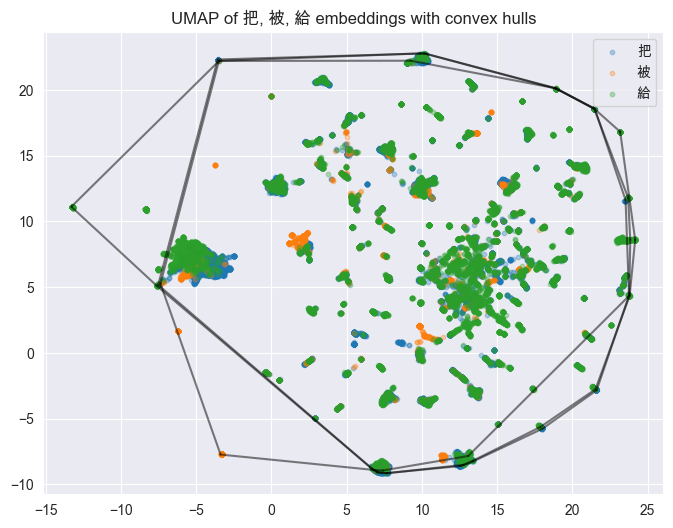

In [18]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'Arial Unicode MS'  # Chinese support

plt.figure(figsize=(8,6))
for word in set(true_labels):
    idx = [i for i, l in enumerate(true_labels) if l == word]
    points = emb_2d[idx]
    plt.scatter(points[:,0], points[:,1], alpha=0.3, s=10, label=word)
    
    if len(points) > 3:  # ConvexHull needs at least 3 points
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex,0], points[simplex,1], c='k', alpha=0.5)

plt.legend()
plt.title("UMAP of 把, 被, 給 embeddings with convex hulls")
plt.show()


## Per-word centroids (average embedding) 

In [21]:
import numpy as np
from collections import defaultdict

# Prepare dictionary for centroids
centroids = defaultdict(lambda: None)

# words you care about
words = set(true_labels)

for word in words:
    # select embeddings for this word
    vectors = np.array([emb for emb, lbl in zip(embeddings, true_labels) if lbl == word])
    # compute mean embedding
    centroids[word] = np.mean(vectors, axis=0)

# quick check
for word in centroids:
    print(word, centroids[word][:5])  # print first 5 dimensions


把 [ 0.1482349  -0.06013146 -0.28024292  0.43026915  0.41351643]
被 [0.33337516 0.08933382 0.08960355 0.1721404  0.5018023 ]
給 [ 0.17180957  0.0178116  -0.09246018  0.41008988  0.27186963]


In [22]:
from sklearn.metrics.pairwise import cosine_similarity

words = list(centroids.keys())
for i, w1 in enumerate(words):
    for j, w2 in enumerate(words):
        if j <= i:
            continue  # skip duplicates and self-comparison
        sim = cosine_similarity(centroids[w1].reshape(1, -1), centroids[w2].reshape(1, -1))[0,0]
        print(f"Cosine similarity between {w1} and {w2}: {sim:.3f}")


Cosine similarity between 把 and 被: 0.925
Cosine similarity between 把 and 給: 0.967
Cosine similarity between 被 and 給: 0.934


In [23]:
from sklearn.metrics.pairwise import cosine_distances
from collections import defaultdict
import numpy as np

# dictionary for within-word variability
variability = defaultdict(float)

for word in set(true_labels):
    # select embeddings for this word
    vectors = np.array([emb for emb, lbl in zip(embeddings, true_labels) if lbl == word])
    # compute pairwise cosine distances
    dists = cosine_distances(vectors)
    # average off-diagonal distances
    n = len(vectors)
    if n > 1:
        variability[word] = dists[np.triu_indices(n, k=1)].mean()
    else:
        variability[word] = 0.0

# check results
for word in variability:
    print(f"Average within-word distance for {word}: {variability[word]:.3f}")


Average within-word distance for 把: 0.558
Average within-word distance for 被: 0.559
Average within-word distance for 給: 0.567


In [24]:
import numpy as np
from collections import defaultdict

words = ['把', '被', '給']

# Store results
centroids_by_age = defaultdict(dict)       # centroids_by_age[word][age] = mean embedding
overlap_by_age = defaultdict(dict)         # overlap_by_age[age][(w1,w2)] = cosine similarity
variability_by_age = defaultdict(dict)     # variability_by_age[word][age] = avg within-word distance


In [27]:
import os
import pickle
import numpy as np
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

input_dir = "char_embeddings_by_group_all_with_utts"
words = ['把', '被', '給']
valid_ages = set(str(age) for age in range(2, 7))  

# storage
centroids_by_age = defaultdict(dict)
variability_by_age = defaultdict(dict)
overlap_by_age = defaultdict(dict)

# loop through child files (age-grouped)
for filename in os.listdir(input_dir):
    age = filename.split("_")[1].replace(".pkl","")
    if age not in valid_ages:
        continue  # skip files not in 2-6
    
    if filename.startswith("child") and filename.endswith(".pkl"):
        age = filename.split("_")[1].replace(".pkl","")
        with open(os.path.join(input_dir, filename), "rb") as f:
            data = pickle.load(f)  # data is a dict: {'把': [(vec,sent)], ...}

        # centroids and within-word variability
        for word in words:
            if word in data and len(data[word]) > 0:
                vectors = np.array([vec for vec, sent in data[word]])
                centroids_by_age[word][age] = np.mean(vectors, axis=0)
                if len(vectors) > 1:
                    dists = cosine_distances(vectors)
                    variability_by_age[word][age] = dists[np.triu_indices(len(vectors), k=1)].mean()
                else:
                    variability_by_age[word][age] = 0.0

        # overlaps between words
        for i, w1 in enumerate(words):
            for j, w2 in enumerate(words):
                if j <= i: 
                    continue
                if w1 in data and w2 in data:
                    sim = cosine_similarity(
                        centroids_by_age[w1][age].reshape(1,-1),
                        centroids_by_age[w2][age].reshape(1,-1)
                    )[0,0]
                    overlap_by_age[age][(w1,w2)] = sim

# quick check
print("Centroids by age:", {w: dict(centroids_by_age[w]) for w in words})
print("Variability by age:", {w: dict(variability_by_age[w]) for w in words})
print("Sample overlap for first age:", next(iter(overlap_by_age.items())))


Centroids by age: {'把': {'2': array([ 5.25709987e-02,  1.54247070e-02, -1.60109445e-01,  3.39998603e-01,
        4.74650532e-01, -2.19256580e-01,  8.20174366e-02, -3.83490324e-01,
       -5.72504222e-01,  4.92421389e-01,  1.37720898e-01, -1.39361560e-01,
        3.09782386e-01,  1.03603907e-01,  7.57432997e-01, -7.82001257e-01,
        6.29161000e-01,  4.43911180e-02,  2.65545368e-01, -5.79769798e-02,
       -1.01218395e-01,  2.65198410e-01, -1.52759403e-01,  4.97123180e-03,
        2.52158016e-01, -1.66232273e-01, -6.47296250e-01, -3.78625780e-01,
        2.77419448e-01,  3.13014448e-01, -6.20382838e-02,  2.39633061e-02,
       -6.37666821e-01, -5.66945178e-03,  8.70205648e-03, -2.80355155e-01,
        3.70148093e-01, -1.34391725e-01, -1.68308139e-01, -5.49542964e-01,
       -8.78433436e-02,  9.40073282e-02, -4.22249138e-01,  2.94823289e-01,
        1.61452994e-01, -1.34110793e-01, -2.91246772e-01,  4.87584233e-01,
       -3.25442761e-01,  2.56091297e-01,  2.18351170e-01,  9.92118073e

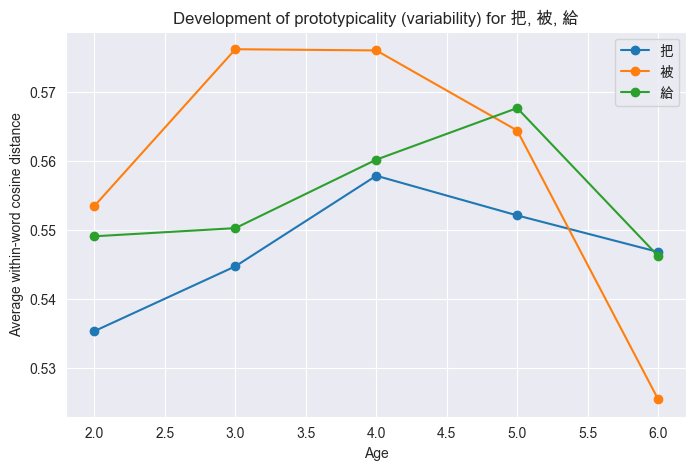

In [28]:
import matplotlib.pyplot as plt

words = ['把', '被', '給']
ages = sorted([int(a) for a in centroids_by_age['把'].keys()])  # only ages we have

plt.figure(figsize=(8,5))
for word in words:
    vals = [variability_by_age[word][str(age)] for age in ages]
    plt.plot(ages, vals, marker='o', label=word)
plt.xlabel("Age")
plt.ylabel("Average within-word cosine distance")
plt.title("Development of prototypicality (variability) for 把, 被, 給")
plt.legend()
plt.show()


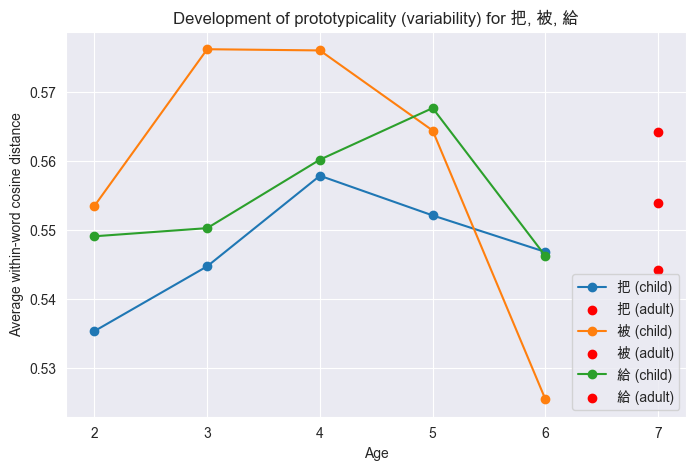

In [29]:
# load adult embeddings and compute variability
adult_variability = {}
import os, pickle
from sklearn.metrics.pairwise import cosine_distances

input_dir = "char_embeddings_by_group_all_with_utts"
words = ['把', '被', '給']

for word in words:
    filename = f"adult_{word}.pkl"
    with open(os.path.join(input_dir, filename), "rb") as f:
        data = pickle.load(f)  # data is a list of (vec, sentence)
    vectors = np.array([vec for vec, sent in data])
    if len(vectors) > 1:
        dists = cosine_distances(vectors)
        adult_variability[word] = dists[np.triu_indices(len(vectors), k=1)].mean()
    else:
        adult_variability[word] = 0.0

# plot with adults
import matplotlib.pyplot as plt

ages = sorted([int(a) for a in centroids_by_age['把'].keys()])
plt.figure(figsize=(8,5))
for word in words:
    vals = [variability_by_age[word][str(age)] for age in ages]
    plt.plot(ages, vals, marker='o', label=f"{word} (child)")
    plt.scatter([max(ages)+1], [adult_variability[word]], color='red', label=f"{word} (adult)")
plt.xlabel("Age")
plt.ylabel("Average within-word cosine distance")
plt.title("Development of prototypicality (variability) for 把, 被, 給")
plt.legend()
plt.show()


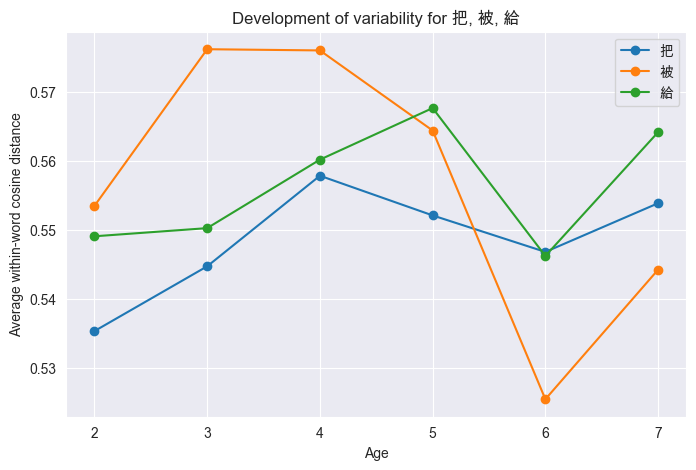

In [31]:
# extend ages to include adults as 7
ages_extended = ages + [7]

plt.figure(figsize=(8,5))
for word in words:
    vals = [variability_by_age[word][str(age)] for age in ages] + [adult_variability[word]]
    plt.plot(ages_extended, vals, marker='o', label=word)
plt.xlabel("Age")
plt.ylabel("Average within-word cosine distance")
plt.title("Development of variability for 把, 被, 給")
plt.legend()
plt.show()


In [34]:
from sklearn.cluster import KMeans
from collections import defaultdict
import numpy as np

cluster_counts = defaultdict(dict)  # cluster_counts[word][age]

for word in words:
    for age in ages:
        # get embeddings for this word and age
        vectors = np.array([emb for emb, lbl in zip(embeddings, true_labels) if lbl == word])
        n = len(vectors)
        if n < 2:
            cluster_counts[word][age] = 1
            continue
        # choose n_clusters; for example, just use min(5, n) or any number you prefer
        n_clusters = n if n <= 5 else 5  # or pick your own heuristic
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(vectors)
        cluster_counts[word][age] = n_clusters


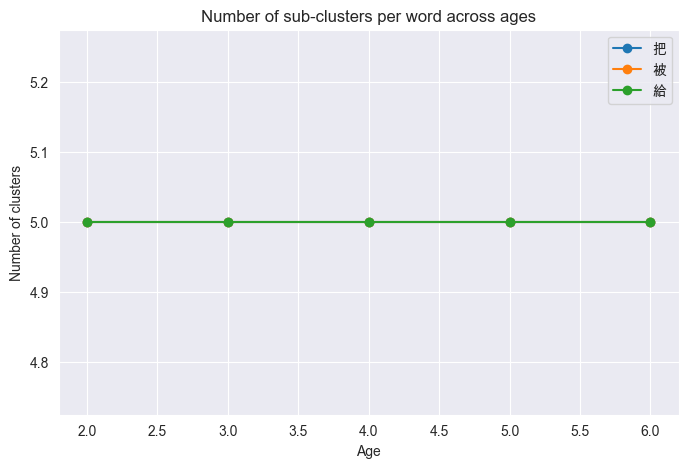

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for word in words:
    vals = [cluster_counts[word][age] for age in ages]
    plt.plot(ages, vals, marker='o', label=word)
plt.xlabel("Age")
plt.ylabel("Number of clusters")
plt.title("Number of sub-clusters per word across ages")
plt.legend()
plt.show()
